# IMPORTS 

In [1]:
from processing.utils import *
from processing.utils2 import *
from processing.utils3 import *
#from processing.plotting import *
from processing.gpcrdb_soup import *

In [2]:
import sys
import functools
import operator
import random
from tqdm import tqdm, trange
import time
import pandas
from scipy.spatial.distance import pdist, squareform
from math import degrees
import mplcursors
import requests as r
from urllib.request import urlopen
from Bio import SeqIO, pairwise2
from io import StringIO
import gemmi
from gemmi import cif

# PROCESSOR

In [3]:
class CifProcessor():
    def __init__(self, 
                 path = 'data/',
                 structure = 'mmcif/',
                 starting_idx=0,
                 limit=None,
                 shuffle = False,
                 reload=True,
                 remove_hetatm=True,
                 allow_exception=False):
        self.path = path
        self.structure_path = self.path + structure
        self.path_table = path + 'gpcrdb/' + 'table.pkl'
        
        self.shuffle = shuffle
        self.limit = limit
        self.reload = reload
        self.remove_hetatm = remove_hetatm
        self.allow_exception = allow_exception
        
        self.filenames, self.pdb_ids = self.get_pdb_files()
        self.filenames = self.filenames[starting_idx:]
        self.pdb_ids = self.pdb_ids[starting_idx:]
        if self.limit == None:
            self.limit = len(self.pdb_ids)
        if len(self.filenames) > self.limit:
            self.filenames = self.filenames[:self.limit]
            self.pdb_ids = self.pdb_ids[:self.limit]
        # Columns for structure dataframe
        self.cols = ['group_PDB', 'auth_asym_id', 'label_asym_id', 'label_seq_id', 'auth_seq_id', 
                     'label_comp_id', 'id', 'label_atom_id', 
                     'type_symbol', 'Cartn_x', 'Cartn_y', 'Cartn_z']
        self.numbering = pd.DataFrame()
        self.dfl_list = []
        
    # ==============================================================================================================
    
    def get_pdb_files(self):
        # just a helper function that returns all pdb files in specified path
        (_, _, filenames) = next(os.walk(self.structure_path))
        if self.shuffle:
            random.shuffle(filenames)
        files = [self.structure_path + x for x in filenames]
        pdb_ids = list(set([x[-8:-4] for x in files]))
        return files, pdb_ids
    
    def get_metatable(self):        
        self.table = pd.read_pickle(self.path_table)
        self.table.to_pickle(self.path + 'data_table.pkl')
    
    def make_metainfo(self):
        for i, pdb_id in tqdm(enumerate(self.pdb_ids)):
            if i < self.limit:
                protein, family = self.get_prot_info(pdb_id)
                if protein == None:
                    pass
                else:
                    numbering = self.get_res_nums(protein)
                    if i == 0:
                        self.mappings = self.get_mapping(pdb_id)
                        numb = pd.DataFrame([pdb_id, protein, family, numbering]).T
                        # numb = [pdb_id, protein, self.entry_to_ac(protein), family, numbering]
                        numb.columns = ['PDB', 'identifier', 'family', 'numbering']
                        self.numbering = self.numbering.append(numb)
                    else:
                        self.mappings = self.mappings.append(self.get_mapping(pdb_id), ignore_index=True)
                        numb = pd.DataFrame(data=[pdb_id, protein, family, numbering]).T
                        numb.columns = ['PDB', 'identifier', 'family', 'numbering']
                        self.numbering = self.numbering.append(numb, ignore_index=True)

    def make_raws(self):
        for i, pdb_id in tqdm(enumerate(self.pdb_ids)):
            if i < self.limit:
                # only process if the file has not already been generated
                # if not self.reload & 
                protein, family = self.get_prot_info(pdb_id)
                if protein != None:
                    if i == 0:
                        self.structure = self.load_cifs(pdb_id)
                        self.structure['identifier'] = protein.upper()
                        if self.remove_hetatm:
                            self.structure = self.structure[self.structure['group_PDB']!='HETATM']
                            self.structure['label_seq_id'] = self.structure['label_seq_id'].astype(np.int64)
                        self.structure['label_comp_sid'] = self.structure.apply(lambda x:
                                                            gemmi.find_tabulated_residue(x.label_comp_id).one_letter_code, 
                                                            axis=1)
                    else:
                        structure = self.load_cifs(pdb_id)
                        structure['identifier'] = protein.upper()
                        if self.remove_hetatm:
                            structure = structure[structure['group_PDB']!='HETATM']
                            structure['label_seq_id'] = structure['label_seq_id'].astype(np.int64)
                        structure['label_comp_sid'] = structure.apply(lambda x:
                                                            gemmi.find_tabulated_residue(x.label_comp_id).one_letter_code, 
                                                            axis=1)
                        self.structure = self.structure.append(structure, ignore_index=True)
         
    # ==============================================================================================================
        
    def entry_to_ac(self, entry: str):
        query = 'https://www.uniprot.org/uniprot/'+entry+'.txt'
        response = requests.get(query)
        return response.text.split('\n')[1].split('AC   ')[1][:6]
    
    def get_prot_info(self, pdb_id):
        # query structure
        query = 'https://gpcrdb.org/services/structure/'+pdb_id.upper()+'/'
        response = requests.get(query)
        if len(response.json()) > 0:
            protein = response.json()['protein']
            family = response.json()['family']
            return protein, family
        else:
            return None, None
    
    def get_res_nums(self, protein):
        # query uniprot -> res num
        query = 'https://gpcrdb.org/services/residues/extended/'+protein+'/'
        response = requests.get(query)
        # select res num
        # assign res_num to structure data
        return response.json()
    
    def get_mapping(self, pdb_id):
        maps = get_mappings_data(pdb_id)[pdb_id.lower()]['UniProt']
        uniprots = maps.keys()
        full_table=pd.DataFrame()
        for i, uniprot in enumerate(uniprots):
            table = pd.DataFrame.from_dict(maps[uniprot])
            table['PDB'] = pdb_id
            table['uniprot'] = uniprot
            if i == 0:
                full_table = table
            else:
                full_table = full_table.append(table, ignore_index=True)
        return full_table
    
    # ==============================================================================================================
    
    def load_cifs(self, pdb_id):
        path = 'data/mmcif/' + pdb_id + '.cif'
        try:
            doc = cif.read_file(path)  # copy all the data from mmCIF file
            lol = []  # list of lists
            for b, block in enumerate(doc):
                table = block.find('_atom_site.', self.cols)
                for row in table:
                    lol.append([pdb_id]+list(row))
        
        except Exception as e:
            print("Hoppla. %s" % e)
            sys.exit(1)
        cols = ['PDB']+self.cols
        st = gemmi.read_structure(path)
        model = st[0]
        if len(st) > 1:
            print("There are multiple models!")
        rol = []
        for chain in model:
            for r, res in enumerate(chain.get_polymer()):
                # previous_residue() and next_residue() return previous/next
                # residue only if the residues are bonded. Otherwise -- None.
                prev_res = chain.previous_residue(res)
                next_res = chain.next_residue(res)
                try:
                    phi, psi = gemmi.calculate_phi_psi(prev_res, res, next_res)
                except:
                    phi, psi = np.nan, np.nan
                try:
                    omega = gemmi.calculate_omega(res, next_res)
                except:
                    omega = np.nan
                rol.append([res.label_seq, res.subchain, 
                            degrees(phi), degrees(omega), degrees(psi)])
        cols2 = ['label_seq_id', 'label_asym_id', 'phi', 'omega', 'psi']
        rol_df = pd.DataFrame(data=rol, columns=cols2)
        rol_df['label_seq_id'] = rol_df['label_seq_id'].astype(int)
        lol_df = pd.DataFrame(data=lol, columns=cols)
        lol_df['label_seq_id'] = lol_df.apply(lambda x: int(x.label_seq_id) if x.label_seq_id != '.' else np.nan, axis=1)
        return pd.merge(lol_df, rol_df, how='inner', on=['label_asym_id', 'label_seq_id'])
    
    # ==============================================================================================================   
            
    def to_pkl_metainfo(self):
        self.numbering.to_pickle(self.path + 'data_numbering.pkl')
        self.table.to_pickle(self.path + 'data_table.pkl')
        self.mappings.to_pickle(self.path + 'data_mappings.pkl')
    
    def to_pkl_raw(self, folder='data/raw/', overwrite=False):
        for pdb_id in self.pdb_ids:
            structure = self.structure[self.structure['PDB']==pdb_id]
            if len(structure) >= 1:
                if (not os.path.isfile(folder + pdb_id + '.pkl')) or overwrite:
                    structure.to_pickle(folder + pdb_id + '.pkl')
                    print("writing to file:", folder + pdb_id + '.pkl')
    
    def to_pkl_processed(self, folder='data/processed/', overwrite=False):
        for df in self.dfl:
            pdb_id = df['PDB'].unique()[0]
            if (not os.path.isfile(folder + pdb_id + '.pkl')) or overwrite:
                df.to_pickle(folder + pdb_id + '.pkl')
                print("writing to file:", folder + pdb_id + '.pkl')
    
    # ==============================================================================================================   
    
    def del_pkl(self, folder='data/raw/'):
        files = [f for f in os.listdir(folder) if '.pkl' in f]
        for file in files:
            os.remove(folder + file)
    
    def del_pkl_metainfo(self):
        os.remove(self.path + 'data_numbering.pkl')
        os.remove(self.path + 'data_table.pkl')
        os.remove(self.path + 'data_mappings.pkl')
            
    # ==============================================================================================================
    
    def read_pkl_raw(self):
        # not needed atm
        pass
    
    def read_pkl_processed(self, mode='', folder='data/processed/'):
        files = [f for f in os.listdir(folder) if '.pkl' in f]
        
        if 'g' in mode:
            # remove all files with "g-ending" -> refers to already processed data
            files = [f for f in files if 'g.' not in f]
            
        if 'r' in mode:
            files = [f for f in files if '_f' not in f]
        
        self.dfl = []
        for f in files:
            self.dfl.append(pd.read_pickle(folder+f).reset_index().drop('index', axis=1))
            
            if len(f) == 8:
                self.dfl_list.append(f[:-4])
            elif len(f) == 11:
                self.dfl_list.append(f[:-7])
            else:
                self.dfl_list.append('')
    
    def read_pkl_metainfo(self):
        self.numbering = pd.read_pickle(self.path + 'data_numbering.pkl')
        self.table = pd.read_pickle(self.path + 'data_table.pkl')
        self.mappings = pd.read_pickle(self.path + 'data_mappings.pkl')
    
    # ==============================================================================================================    
    
    def get_stacked_maps(self, pdb):
        # add gene to mapping
        mappings_ = self.mappings[self.mappings['PDB']==pdb]
        pref_chain = self.table[self.table['PDB']==pdb.upper()]['Preferred Chain'].iloc[0]
        map_df_list = []
        for j in range(len(mappings_)):
            chain = pd.DataFrame.from_dict(mappings_.iloc[j]['mappings'])['chain_id'].iloc[0]
            identifier = mappings_.iloc[j]['name']
            dict_ = pd.DataFrame.from_dict(mappings_.iloc[j]['mappings'])
            dict_['identifier'] = identifier
            map_df_list.append(pd.DataFrame.from_dict(dict_))
        _ = pd.concat(map_df_list)
        _ = _[_['chain_id']==pref_chain]
        _['PDB'] = pdb
        return _


    def get_generic_nums(self, pdb_id):
        sequence_numbers = []
        amino_acids = []
        generic_numbers = []
        for i in self.numbering[self.numbering['PDB']==pdb_id].iloc[0]['numbering']:
            if i['alternative_generic_numbers'] != []:
                sequence_numbers.append(i['sequence_number'])
                amino_acids.append(i['amino_acid'])
                generic_numbers.append(i['display_generic_number'])
        return list(zip(sequence_numbers, amino_acids, generic_numbers))


    def get_generic_number(self, zipped_pos_dict, l2u, comp_sid):
        if l2u >= 0:
            if l2u in list(zip(*zipped_pos_dict))[0]:
                idx = list(zip(*zipped_pos_dict))[0].index(l2u)
                row = zipped_pos_dict[idx]
                if row[1] == comp_sid:
                    return row[2], row[1], float(row[2].split('x')[0]), int(row[2].split('x')[1])
                else:
                    return row[2]+'?', row[1], float(row[2].split('x')[0]), int(row[2].split('x')[1])
            else:
                return ['', '', 0, 0]
        else:
            return ['', '', 0, 0]


    def assign_generic_numbers_(self, pdb_id, overwrite, folder):
        data = pd.read_pickle(folder + pdb_id + '.pkl').reset_index().drop('index', axis=1)
        print("loaded data to assign gen. numbers from", folder + pdb_id + '.pkl')
        cols = data.columns
        columns = ['gen_pos', 'gen_pos1', 'gen_pos2', 'uniprot_comp_sid']
        _ = [i for i in columns if i in cols]
        if len(_) > 0:
            if overwrite:
                data.drop(_, axis=1, inplace=True)
                data['label_2_uni'] = 0
                data[columns[0]] = ''
                data[columns[1]] = 0
                data[columns[2]] = 0
                data[columns[3]] = ''
            else:
                return data
        else:
            data['label_2_uni'] = 0
            data[columns[0]] = ''
            data[columns[1]] = 0
            data[columns[2]] = 0
            data[columns[3]] = ''
        maps_stacked = self.get_stacked_maps(pdb_id)
        if 'residue_number' in maps_stacked.index:
            pass
        else:
            return data
        if type(maps_stacked[maps_stacked['PDB']==pdb_id].\
                loc['residue_number'][['chain_id', 'start','end','unp_start','unp_end', 'identifier', 'PDB']])\
                    == pandas.core.series.Series:
            pref_mapping = maps_stacked[maps_stacked['PDB']==pdb_id].loc['residue_number']\
                [['chain_id', 'start','end','unp_start','unp_end', 'identifier', 'PDB']].to_frame().T
        else:
            pref_mapping = maps_stacked[maps_stacked['PDB']==pdb_id].\
                loc['residue_number'][['chain_id', 'start','end','unp_start','unp_end', 'identifier', 'PDB']]
        pref_chain = pref_mapping['chain_id'].iloc[0]
        pref_mapping = pref_mapping.sort_values('start')
        uniprot_identifier_ = data[data['PDB']==pdb_id]['identifier'].unique()
        uniprot_identifier = uniprot_identifier_[0]
        natoms = len(data[data['PDB']==pdb_id])
        
        for j in range(len(pref_mapping)):
            row = pref_mapping.iloc[j].to_dict()
            map_identifier = row['identifier']
            map_pdb = row['PDB']
            start_label_seq_id = row['start']
            start_uniprot = row['unp_start']
            end_label_seq_id = row['end']
            end_uniprot = row['unp_end']
            if map_identifier == uniprot_identifier:
                idxs = [x for x in range(natoms+1) \
                        if ((x <= end_label_seq_id) & (x >= start_label_seq_id))]
                vals = [x + start_uniprot - start_label_seq_id for x in range(natoms+1) \
                        if ((x <= end_label_seq_id) & (x >= start_label_seq_id))]
                for k, idx in enumerate(idxs):
                    line = data[(data['PDB'] == pdb_id) &
                                (data['label_seq_id'] == idx) &
                                (data['label_atom_id'] == 'CA')]
                    lines = len(line)
                    if len(line) > 1:
                        line = line[line['auth_asym_id'] == pref_chain]
                    if len(line) > 0:
                        data.at[line.index[0], 'label_2_uni'] = int(vals[k])
            else:
                # Didnt find correct uniprotmap (not a gpcr) ==> map_identifier
                pass
        # Generate generic numbers
        zipped_pos_dict = self.get_generic_nums(pdb_id)
        if type(data) == pandas.core.series.Series:
            data = data.to_frame().T
        
        data[['gen_pos', 'uniprot_comp_sid', 'gen_pos1', 'gen_pos2']] = data.\
            apply(lambda x: self.get_generic_number(zipped_pos_dict, x.label_2_uni, x.label_comp_sid) if x.PDB==pdb_id\
                  else [x.gen_pos, x.uniprot_comp_sid, x.gen_pos1, x.gen_pos2], axis=1, result_type='expand')
        return data
    
    def assign_generic_numbers(self, pdb_ids=None, overwrite=True, folder='data/raw/'):
        dfl_ = []
        if pdb_ids != None:
            self.pdb_ids = pdb_ids
        if not isinstance(self.pdb_ids, list):
            self.pdb_ids = [self.pdb_ids]
        for pdb_id in self.pdb_ids:
            if self.allow_exception:
                print("trying to assign generic nubmers to", pdb_id)
                try:
                    dfl_.append(self.assign_generic_numbers_(pdb_id, overwrite=overwrite, folder=folder))
                    print("assigned generic numbers to", pdb_id, "\n\n\n")
                except:
                    print("assigning failed for", pdb_id)
            else:
                print("trying to assign generic nubmers to", pdb_id)
                dfl_.append(self.assign_generic_numbers_(pdb_id, overwrite=overwrite, folder=folder))
                print("assigned generic numbers to", pdb_id, "\n\n\n")
        self.dfl = dfl_
        del dfl_
        
    # ==============================================================================================================
    
    def plot_angles_for_gen_pos(self, region=[7.40, 7.60], legend=True):
        categories = []
        for df in self.dfl:
            category = np.unique(df['PDB'])[0]
            categories.append(category)

        cmap = plt.cm.get_cmap('RdYlGn', len(categories))
        colors = np.linspace(0, len(categories)-1, len(categories))
        colordict = dict(zip(categories,colors))

        fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(24,12))

        xlabel = 'generic position numbers'
        ylabel = 'degrees'

        xtick_min = region[0]
        xtick_max = region[1]

        nsteps = int(round(xtick_max - xtick_min, 2) / 0.01)
        xticks = np.linspace(xtick_min, xtick_max, nsteps+1)

        for i, cat in enumerate(categories):
            c = int(colordict[cat])
            df = self.dfl[i]
            roi = df[(df['gen_pos1']>=region[0]) & 
                     (df['gen_pos1']<region[1]) & 
                     (df['label_atom_id']=='CA')].copy()
            roi['phi'] = roi.apply(lambda x: float(x.phi), axis=1)
            roi['omega'] = roi.apply(lambda x: float(x.omega), axis=1)
            roi['psi'] = roi.apply(lambda x: float(x.psi), axis=1)
            tot_len = len(roi['phi'].to_list())+len(roi['omega'].to_list())+len(roi['psi'].to_list())
            if tot_len > 0:
                roi.plot(kind='line', x='gen_pos1', y='phi', 
                        ax = axes[0], subplots = True, color = cmap(c), 
                        xticks = xticks, label=cat)
                if legend:
                    axes[0].legend(bbox_to_anchor=(1.0, 1.0))
                axes[0].set_xlabel(xlabel)
                axes[0].set_ylabel(ylabel)
                axes[0].set_title('Psi Angles')

                roi.plot(kind='line', x='gen_pos1', y='psi', 
                        ax = axes[1], subplots = True, color = cmap(c), 
                        xticks = xticks, label=cat)
                if legend:
                    axes[1].legend(bbox_to_anchor=(1.0, 1.0))
                axes[1].set_xlabel(xlabel)
                axes[1].set_ylabel(ylabel)
                axes[1].set_title('Phi Angles')
        plt.show()
        
    def get_family():
        # TBD: PROBLEM: HOW TO GROUP THEM
        pass

In [4]:
data = CifProcessor()

In [5]:
data.get_metatable()

In [6]:
data.read_pkl_metainfo()

In [7]:
data.read_pkl_processed()

In [8]:
def load_gen_res_nums_gprot(path='data/alignments/residue_table.xlsx'):
    res_table = pd.read_excel(path, engine='openpyxl')
    keep_cols = ['CGN',
             'G(s) subunit alpha isoforms short Human', 
             'G(t) subunit alpha-1 Human', 
             'G(i) subunit alpha-1 Human', 'G(i) subunit alpha-2 Human', 
             'G(o) subunit alpha Human',
             'G(q) subunit alpha Human',
             'subunit alpha-11 Human']
    drop_cols = [x for x in res_table.columns if x not in keep_cols]
    res_table=res_table.drop(drop_cols, axis=1)
    res_table.columns = ['CGN', 'Gs', 'Gta1', 'Gia1', 'Gia2', 'Go', 'Gq', 'G11']
    # These are the rows corresponding to "beginnings/ends" of new G protein sections (nan rows)
    res_table = res_table.drop(res_table[res_table.iloc[:, 1:].isnull().all(1)].index).reset_index(drop=True)
    domain_list = res_table[res_table.iloc[:, 1:].isnull().all(1)]['CGN'].to_list()
    return res_table, domain_list

In [9]:
def filter_dfl_via_table(data,
                         Species=None,
                         State=None,
                         Family=None,
                         Subtype=None,
                         Resolution=None,
                         Function=None,
                         gprotein=False):
    if Species != None:
        data = data[data['Species']==Species]
    if State != None:
        data = data[data['State']==State]
    if Family != None:
        data = data[data['Family']==Family]
    if Subtype != None:
        data = data[data['Subtype']==Subtype]
    if Resolution != None:
        data = data[data['Resolution']<=Resolution]
    if Function != None:
        data = data[data['Species']==Function]
    if gprotein:
        data = _filter_table_via_gprotein(data)
    return data

In [10]:
def _filter_table_via_gprotein(table):
    allowed_Fam_ = ['Gi/o', 'Gs', 'Gq/11']
    allowed_Fam = '|'.join(allowed_Fam_)
    allowed_Sub_ = ['αi1', 'αi2', 'αs', 'αo', 'α11', 'αq', 'αt1']
    allowed_Sub = '|'.join(allowed_Sub_)
    table = table[table['Family'].str.contains(allowed_Fam) &
                  table['Subtype'].str.contains(allowed_Sub)].reset_index(drop=True)
    return table

In [11]:
def _get_res_num_df(res_table, subtype):
    res_num_dict = {}
    for i in range(len(res_table)):
        if res_table[subtype].iloc[i] != '-':
            idx = res_table['CGN'].iloc[i]
            _ = res_table[subtype].iloc[i]
            res = _[0]
            pos = _[1:]
            res_num_dict[int(pos)] = (res, idx)
    df = pd.DataFrame(res_num_dict).T
    df.columns = ['res', 'idx']
    return df

In [12]:
def _get_uniprot_gprot_seqs(uniprot_gprot_list):
    baseUrl="http://www.uniprot.org/uniprot/"
    gprot_uniprot_seq_dict = {}
    print("Downloading uniprot gprotein sequences...")
    for code in tqdm(uniprot_gprot_list):
        # get uniprot sequence
        time.sleep(1)
        try:
            currentUrl=baseUrl + code + ".fasta"
            response = r.post(currentUrl)
            cData=''.join(response.text)
            Seq=StringIO(cData)
            pSeq=list(SeqIO.parse(Seq,'fasta'))
            pSeq0 = pSeq[0]
            seq = str(pSeq0.seq)
            gprot_uniprot_seq_dict[code] = seq
        except:
            gprot_uniprot_seq_dict[code] = ''
    return gprot_uniprot_seq_dict

In [13]:
def _label_uniprot_gprot_seqs(gprot_df, res_table):
    # for each gprotein (uniprot) compare their sequence with the provided residue number sequence
    pass

In [14]:
def get_gproteins_in_complex_df(uniprot_dict, g_dict2, res_table):
    uniprot_gprot_list = functools.reduce(operator.iconcat, list(uniprot_dict.values()), [])
    def _get_uniprot_types(uniprot, uniprot_dict, g_dict):
        for i, u in enumerate(list(uniprot_dict.values())):
            if uniprot in u:
                idx = u.index(uniprot)
                subtype = list(uniprot_dict.keys())[i]
                return subtype, g_dict[subtype]
    uniprot_gprot_seq_dict = _get_uniprot_gprot_seqs(uniprot_gprot_list)
    gprot_df = pd.DataFrame(uniprot_gprot_seq_dict.items(), columns=['Uniprot', 'Sequence'])
    gprot_df[['Subtype', 'Family']] = gprot_df\
        .apply(lambda x: _get_uniprot_types(x.Uniprot, uniprot_dict, g_dict2), axis=1, result_type='expand')
    gprot_df['FamilySequence'] = gprot_df.apply(lambda x: ''.join(list(_get_res_num_df(res_table, x.Family)['res'])), axis=1)
    return gprot_df

In [15]:
def annotate_gproteins_in_complex(dfl, dfl_list, mapping, table, res_table, uniprot_dict, g_dict2):
    # for i in range(len(act_table)):
    for i in range(len(table)):
        pdb_id = table.iloc[i]['PDB']
        if pdb_id in dfl_list:
            dfl_idx = dfl_list.index(pdb_id)
            subtype = complex_info['Subtype']
            # print("Corr. uniprot id:", uniprot_dict[subtype])
            pdb_map = mapping[(mapping['PDB'] == pdb_id)]
            pdb_map = pdb_map[pdb_map['uniprot'].isin(uniprot_dict[subtype])]
            if len(pdb_map) > 0:
                print('\n\n\n',pdb_id)
                print("Looking up subtype", 'G'+subtype)
                print(pdb_map['uniprot'])
                res_num_df = _get_res_num_df(res_table, subtype)
    # 1: for each protein check if a gprotein uniprot sequence is present
    # 2: use the sifts mapping to combine cif file and uniprot
    # 3: for each sequence make a dict for the generic residue numbers
    # 4: annotate the gprotein structures

In [16]:
data.dfl_list.index('6FUF')

1180

In [17]:
def get_dfl_indices(data, active_complexes_list):
    return [data.dfl_list.index(active_complexes_list[i]) if (active_complexes_list[i] in data.dfl_list)\
            else None for i in range(len(active_complexes_list))]

In [18]:
filtered = filter_dfl_via_table(data.table, State='Active', gprotein=True)
active_complexes_list = list(filtered['PDB'])

In [19]:
print("family cols: ", list(filtered['Family'].unique()))
print("Subtype cols:", list(filtered['Subtype'].unique()))
print("available:   ", list(filtered.columns))

g_dict1 = {
    'Gs':'αs',
    'Gia1':'αi1',
    'Gia2':'αi2',
    'Go':'αo',
    'Gta1':'αt1',
    'Gq':'αq',
    'G11':'α11',
}

g_dict2 = dict((v,k) for k,v in g_dict1.items())
print('\nDict:', g_dict2)

uniprot_dict = {
    'αi1': ['P63096', 'P63097', 'P10824'],
    'αi2': ['P04899'],
    'αs': ['Q5JWF2', 'P04896', 'P63092'],
    'αo': ['P09471'],
    'α11': ['K7EL62', 'P29992'],
    'αq': ['P50148'],
    'αt1': ['P50148', 'P04695']
}


family cols:  ['Gi/o', 'Gs', 'Gq/11']
Subtype cols: ['αo', 'αs', 'αi1', 'α11', 'αq', 'αi2', 'αt1']
available:    ['uniprot(gene)', 'receptor family', 'Cl.', 'Species', 'Method', 'PDB', 'Resolution', 'Preferred Chain', 'State', 'Degree active %', 'Family', 'Subtype', 'Function']

Dict: {'αs': 'Gs', 'αi1': 'Gia1', 'αi2': 'Gia2', 'αo': 'Go', 'αt1': 'Gta1', 'αq': 'Gq', 'α11': 'G11'}


In [20]:
res_table = load_gen_res_nums_gprot()[0]

In [21]:
gprot_df = get_gproteins_in_complex_df(uniprot_dict, g_dict2, res_table)

  0%|                                                                                                                             | 0/13 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


In [22]:
gprot_df

,Uniprot,Sequence,Subtype,Family,FamilySequence
0,P63096,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...,αi1,Gia1,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...
1,P63097,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...,αi1,Gia1,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...
2,P10824,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...,αi1,Gia1,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...
3,P04899,MGCTVSAEDKAAAERSKMIDKNLREDGEKAAREVKLLLLGAGESGK...,αi2,Gia2,MGCTVSAEDKAAAERSKMIDKNLREDGEKAAREVKLLLLGAGESGK...
4,Q5JWF2,MGVRNCLYGNNMSGQRDIPPEIGEQPEQPPLEAPGAAAPGAGPSPA...,αs,Gs,MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLL...
5,P04896,MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLL...,αs,Gs,MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLL...
6,P63092,MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLL...,αs,Gs,MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLL...
7,P09471,MGCTLSAEERAALERSKAIEKNLKEDGISAAKDVKLLLLGAGESGK...,αo,Go,MGCTLSAEERAALERSKAIEKNLKEDGISAAKDVKLLLLGAGESGK...
8,K7EL62,XLSDSAKYYLTDVDRIATLGYLPTQQDVLRVRVPTTGIIEYPFDLE...,α11,G11,MTLESMMACCLSDEVKESKRINAEIEKQLRRDKRDARRELKLLLLG...
9,P29992,MTLESMMACCLSDEVKESKRINAEIEKQLRRDKRDARRELKLLLLG...,α11,G11,MTLESMMACCLSDEVKESKRINAEIEKQLRRDKRDARRELKLLLLG...


In [23]:
uniprot_gprot_list = functools.reduce(operator.iconcat, list(uniprot_dict.values()), [])

In [24]:
dfl_list = get_dfl_indices(data, active_complexes_list)

In [25]:
def get_stacked_maps(pdb_id, mappings, uniprot_gprot_list):
        # add gene to mapping
        map_df_list = []
        mappings_ = mappings[(mappings['PDB']==pdb_id) & 
                             (mappings['uniprot'].isin(uniprot_gprot_list))]
        uniprots = []
        for j in range(len(mappings_)):
            u = mappings_['uniprot'].iloc[j]
            for k in range(3):
                uniprots.append(u)
            map_df_list.append(pd.DataFrame.from_dict(mappings_['mappings'].iloc[j]))
        _ = pd.concat(map_df_list)
        _['PDB'] = pdb_id
        _['uniprot'] = uniprots
        return _

In [26]:
def _get_res_num_df(res_table, subtype):
    res_num_dict = {}
    for i in range(len(res_table)):
        if res_table[subtype].iloc[i] != '-':
            idx = res_table['CGN'].iloc[i]
            _ = res_table[subtype].iloc[i]
            res = _[0]
            pos = int(_[1:]) + 1   # this + 1 is important?
            res_num_dict[pos] = (res, idx)
    df = pd.DataFrame(res_num_dict).T
    df.columns = ['res', 'idx']
    return df


def _get_pairwise_indices(a, b):
    alignment = pairwise2.align.globalms(a, b, 3, -1, -3, -1)[0]
    indices_a = []
    indices_b = []
    ia = 0
    ib = 0
    assert len(alignment[0][0]) == len(alignment[0][1]), print("?? Alignment length missmatch! ??")
    for i in range(len(alignment[0])):
        ia+=1
        ib+=1
        if alignment[0][i] != '-':
            indices_a.append(ia)
        if alignment[1][i] != '-':
            indices_b.append(ib)
    return alignment[0], indices_a, alignment[1], indices_b


def _make_cgn_df(a, b, res_num_df):
    indices_dict = {}
    j = 0  # index of pointer in a
    k = 0  # index of pointer in b
    for i in range(len(a)):
        if (a[i] != '-') & (b[i] != '-'):
            indices_dict[j] = (a[i], b[i], k, res_num_df.iloc[k]['idx'])
            j+=1
            k+=1
        elif (a[i] == '-') & (b[i] != '-'):
            # we do not update our dict (since we dont care about anything not within our sequence/structure)
            k+=1
        elif (a[i] != '-') & (b[i] == '-'):
            indices_dict[j] = (a[i], '-', -1, '-')
            j+=1
        else:
            # this should not exist
            pass
    cgn_df = pd.DataFrame.from_dict(indices_dict).T
    cgn_df.columns = ['seq_res', 'fam_seq_res', 'fam_seq_pos', 'cgn']
    return cgn_df


def get_cgn_df(gprot_df, idx, res_table):
    f = gprot_df.iloc[idx]['Family']
    a = gprot_df.iloc[idx]['Sequence']
    b = gprot_df.iloc[idx]['FamilySequence']
    a, _, b, _ = _get_pairwise_indices(a, b)
    res_num_df = _get_res_num_df(res_table, f)
    return _make_cgn_df(a, b, res_num_df)

In [27]:
assign_res_nums = None

In [28]:
def assign_res_nums(pdb_id, mappings, structure, uniprot_gprot_list, gprot_df, res_table):
    try:
        maps_stacked = get_stacked_maps(pdb_id, mappings, uniprot_gprot_list)
    except:
        return structure
    if 'residue_number' in maps_stacked.index:
        pass
    else:
        return structure
    
    selection = maps_stacked[maps_stacked['PDB']==pdb_id]
    
    if type(selection.loc['residue_number']) == pandas.core.series.Series:
        mapping = selection.loc['residue_number'].to_frame().T
    else:
        mapping = selection.loc['residue_number']
    
    mapping = mapping.sort_values('start')
    nres = max(list(structure[structure['PDB']==pdb_id]['label_seq_id']))

    for j in range(len(mapping)):
        row = mapping.iloc[j].to_dict()
        
        pref_chain = row['chain_id']
        
        uniprot = row['uniprot']
        
        gprot_idx = list(gprot_df['Uniprot']).index(uniprot)
        
        
        if gprot_idx >= 0:
            cgn_df = get_cgn_df(gprot_df, gprot_idx, res_table)
            
            start_label_seq_id = row['start']
            start_uniprot = row['unp_start']
            end_label_seq_id = row['end']
            end_uniprot = row['unp_end']
                                 
            # the start -> end should be a shift
            # iterate from start_label_seq_id to end_label_seq_id
            
            seq_len = end_label_seq_id - start_label_seq_id

            for k in range(seq_len):
                idx_seq = k + start_label_seq_id
                idx_uni = k + start_uniprot - 1
                line = structure[(structure['PDB'] == pdb_id) &
                                 (structure['label_seq_id'] == idx_seq) &
                                 (structure['label_atom_id'] == 'CA') &
                                 (structure['auth_asym_id'] == pref_chain)]
                
                if len(line) > 0:
                    structure.at[line.index[0], 'label_2_uni'] = idx_uni + 1
                    if line['label_seq_id'].iloc[0] in list(cgn_df.index):
                        structure.at[line.index[0], 'gen_pos'] = cgn_df.iloc[idx_uni]['cgn']
                        structure.at[line.index[0], 'uniprot_comp_id'] = cgn_df.iloc[idx_uni]['seq_res']
                        structure.at[line.index[0], 'fam_comp_id'] = cgn_df.iloc[idx_uni]['fam_seq_res']
                    else:
                        structure.at[line.index[0], 'gen_pos'] = ''
        else:
            return structure
    return structure

In [29]:
for i in trange(len(data.dfl_list)):
    pdb_id = data.dfl_list[i]
    structure = data.dfl[i]
    s = assign_res_nums(pdb_id,
                        data.mappings[data.mappings['PDB']==pdb_id],
                        structure, 
                        uniprot_gprot_list, 
                        gprot_df,
                        res_table)
    data.dfl[i] = s

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2187/2187 [03:00<00:00, 12.11it/s]


In [31]:
count = 0
labelled_complex_ids = []
for i in range(len(data.dfl)):
    s = data.dfl[i]
    if 'gen_pos' in list(s.columns):
        labelled_res = s[(s['label_atom_id']=='CA') &
                         (s['gen_pos'].str.contains('G'))]
        if len(labelled_res) > 0:
            count+=1
            labelled_complex_ids.append(i)

In [32]:
print(count)

217


In [33]:
print(labelled_complex_ids[30])

1124


In [34]:
s = data.dfl[355]

In [36]:
s

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,...,phi,omega,psi,identifier,label_comp_sid,label_2_uni,gen_pos,gen_pos1,gen_pos2,uniprot_comp_sid
0,4IAQ,ATOM,A,A,9,38,TYR,1,N,N,...,NaN,177.942885,136.830839,5HT1B_HUMAN,Y,0,,0.0,0.0,
1,4IAQ,ATOM,A,A,9,38,TYR,2,CA,C,...,NaN,177.942885,136.830839,5HT1B_HUMAN,Y,38,,0.0,0.0,
2,4IAQ,ATOM,A,A,9,38,TYR,3,C,C,...,NaN,177.942885,136.830839,5HT1B_HUMAN,Y,0,,0.0,0.0,
3,4IAQ,ATOM,A,A,9,38,TYR,4,O,O,...,NaN,177.942885,136.830839,5HT1B_HUMAN,Y,0,,0.0,0.0,
4,4IAQ,ATOM,A,A,9,38,TYR,5,CB,C,...,NaN,177.942885,136.830839,5HT1B_HUMAN,Y,0,,0.0,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,4IAQ,ATOM,A,A,400,387,LYS,2748,CB,C,...,-122.952546,NaN,NaN,5HT1B_HUMAN,K,0,,0.0,0.0,
2748,4IAQ,ATOM,A,A,400,387,LYS,2749,CG,C,...,-122.952546,NaN,NaN,5HT1B_HUMAN,K,0,,0.0,0.0,
2749,4IAQ,ATOM,A,A,400,387,LYS,2750,CD,C,...,-122.952546,NaN,NaN,5HT1B_HUMAN,K,0,,0.0,0.0,
2750,4IAQ,ATOM,A,A,400,387,LYS,2751,CE,C,...,-122.952546,NaN,NaN,5HT1B_HUMAN,K,0,,0.0,0.0,


In [35]:
s[(s['label_atom_id']=='CA') &
  (s['gen_pos'].str.contains('G'))]

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,...,phi,omega,psi,identifier,label_comp_sid,label_2_uni,gen_pos,gen_pos1,gen_pos2,uniprot_comp_sid


In [37]:
list_positions = []


for i in range(80):
    s = data.dfl[labelled_complex_ids[i]]
    l = list(s[(s['label_atom_id']=='CA') &
                 (s['gen_pos'].str.contains('G'))]['gen_pos'].unique())
    list_positions = list(set(l) | set(list_positions))

In [38]:
list(set([x.split('.')[1] for x in list_positions]))

['s3h2',
 'HG',
 'hfs2',
 'H4',
 'H1',
 'S5',
 'S3',
 's5hg',
 'HN',
 's2s3',
 's6h5',
 'S4',
 'H5',
 'h4s6',
 'S1',
 'h1ha',
 'S6',
 'h3s5',
 'H3',
 's4h3',
 'H2',
 'hns1',
 'h2s4',
 's1h1',
 'S2',
 'hgh4']

In [39]:
# H5, h4s6, s2s3, hns1

In [40]:
# include spencer's helical features

In [41]:
# annotate_gproteins_in_complex(data.dfl, data.dfl_list, data.mappings, filtered, res_table, uniprot_dict, g_dict2)

In [42]:
path = 'data/mmcif/1GZM.cif'

In [44]:
import MDAnalysis


MDAnalysis.start_logging()
#data = MDAnalysis.analysis.helanal_main(path, select="name CA and resnum 161-187")

MDAnalysis  : INFO     MDAnalysis 1.1.1 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 1.1.1 STARTED logging to 'MDAnalysis.log'


In [45]:
MDAnalysis = None

# Multiindexing

In [85]:
ddfl = data.dfl[4]

In [86]:
ddfl

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,...,phi,omega,psi,identifier,label_comp_sid,label_2_uni,gen_pos,uniprot_comp_sid,gen_pos1,gen_pos2
0,1GZM,ATOM,A,A,2,1,MET,4,N,N,...,-57.618519,-179.911939,122.648638,OPSD_BOVIN,M,NaN,,,0.0,0
1,1GZM,ATOM,A,A,2,1,MET,5,CA,C,...,-57.618519,-179.911939,122.648638,OPSD_BOVIN,M,1.0,,,0.0,0
2,1GZM,ATOM,A,A,2,1,MET,6,C,C,...,-57.618519,-179.911939,122.648638,OPSD_BOVIN,M,NaN,,,0.0,0
3,1GZM,ATOM,A,A,2,1,MET,7,O,O,...,-57.618519,-179.911939,122.648638,OPSD_BOVIN,M,NaN,,,0.0,0
4,1GZM,ATOM,A,A,2,1,MET,8,CB,C,...,-57.618519,-179.911939,122.648638,OPSD_BOVIN,M,NaN,,,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201,1GZM,ATOM,B,B,332,331,ASP,5208,CA,C,...,178.619959,NaN,-55.188607,OPSD_BOVIN,D,NaN,,,0.0,0
5202,1GZM,ATOM,B,B,332,331,ASP,5209,C,C,...,178.619959,NaN,-55.188607,OPSD_BOVIN,D,NaN,,,0.0,0
5203,1GZM,ATOM,B,B,332,331,ASP,5210,O,O,...,178.619959,NaN,-55.188607,OPSD_BOVIN,D,NaN,,,0.0,0
5204,1GZM,ATOM,B,B,332,331,ASP,5211,CB,C,...,178.619959,NaN,-55.188607,OPSD_BOVIN,D,NaN,,,0.0,0


In [87]:
ddfl['id'] = ddfl['id'].astype(int)

In [88]:
mi_ddfl = ddfl.set_index(['PDB', 'label_seq_id', 'auth_seq_id', 'id'])

In [89]:
name = mi_ddfl.index[0][0]

In [90]:
name

'1GZM'

In [91]:
def get_dist_matrix(data):
    x = data[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy()
    return squareform(pdist(x, 'Euclidean'))

In [92]:
from tqdm import trange

In [93]:
distlist = []
res_dict = {}

In [94]:
max_dist = 0
min_dist = 10
for i in trange(len(data.dfl)):
    df = data.dfl[i]
    selection = df[df['label_atom_id']=='CA']
    res_list = selection['label_comp_id'].to_list()
    dists = get_dist_matrix(selection)
    max_dist_ = np.max(dists)
    min_dist_ = np.min(dists)
    if max_dist_ > max_dist:
        max_dist = max_dist_
    if min_dist_ < min_dist:
        min_dist = min_dist_
    distlist.append(dists)
    res_dict.update({i: res_list})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2187/2187 [00:14<00:00, 151.67it/s]


In [95]:
max_dist

264.7805201199665

In [96]:
min_dist

0.0

In [97]:
len(res_dict[0])

643

In [98]:
distlist[0].shape

(643, 643)

In [99]:
heat = distlist[33] / max_dist

In [100]:
k = 1 - heat

In [101]:
for i in range(k.shape[0]):
    for j in range(k.shape[0]):
        if i >= j:
            k[i, j] = np.nan

In [102]:
k

array([[       nan, 0.98582567, 0.97721879, ..., 0.62338086, 0.62434558,
        0.61188861],
       [       nan,        nan, 0.98556744, ..., 0.62096772, 0.62191545,
        0.60921855],
       [       nan,        nan,        nan, ..., 0.63243888, 0.6331318 ,
        0.62029006],
       ...,
       [       nan,        nan,        nan, ...,        nan, 0.98553278,
        0.97817434],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.98559317],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [103]:
mask = (k == np.nan)

<ipython-input-104-988cedda31ef>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlGn"))
  color.set_bad('white')       # if the value is bad the color would be lightblue instead of white


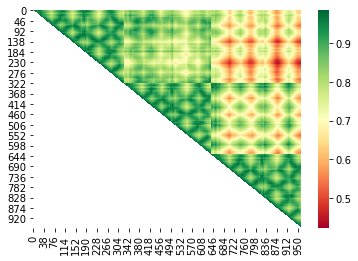

In [104]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

color = plt.get_cmap('RdYlGn')   # default color
color.set_bad('white')       # if the value is bad the color would be lightblue instead of white
h_map = sns.heatmap(data=k, mask=mask, cmap=color)
plt.show()

In [112]:
mi_ddfl[(mi_ddfl['gen_pos1']>7.45) &
        (mi_ddfl['gen_pos1']<8) &
        (mi_ddfl['label_atom_id']=='CA')]

group_PDB auth_asym_id label_asym_id  \
PDB  label_seq_id auth_seq_id id                                          
1GZM 300          299         2375      ATOM            A             A   
     301          300         2380      ATOM            A             A   
     302          301         2387      ATOM            A             A   
     303          302         2399      ATOM            A             A   
     304          303         2407      ATOM            A             A   
     305          304         2414      ATOM            A             A   
     306          305         2421      ATOM            A             A   
     307          306         2429      ATOM            A             A   
     308          307         2441      ATOM            A             A   
     309          308         2449      ATOM            A             A   
     310          309         2457      ATOM            A             A   

                                   label_comp_id label_atom_id type_symbol  \
PDB  label_seq_id auth_seq_id id                                             
1GZM 300          299         2375           ALA            CA           C   
     301          300         2380           VAL            CA           C   
     302          301         2387           TYR            CA           C   
     303          302         2399           ASN            CA           C   
     304          303         2407           PRO            CA           C   
     305          304         2414           VAL            CA           C   
     306          305         2421           ILE            CA           C   
     307          306         2429           TYR            CA           C   
     308          307         2441           ILE            CA           C   
     309          308         2449           MET            CA           C   
     310          309         2457           MET            CA           C   

                                   Cartn_x Cartn_y Cartn_z         phi  \
PDB  label_seq_id auth_seq_id id                                         
1GZM 300          299         2375  47.911  23.159   2.628  -81.632078   
     301          300         2380  49.692  20.658   4.888 -124.828764   
     302          301         2387  48.060  17.220   5.332  -59.421690   
     303          302         2399  48.745  15.786   1.859  -65.530690   
     304          303         2407  52.564  15.787   1.797  -56.771044   
     305          304         2414  52.395  14.282   5.292  -66.616816   
     306          305         2421  50.066  11.445   4.264  -59.629508   
     307          306         2429  52.451  10.982   1.329  -53.573982   
     308          307         2441  55.620  10.770   3.401  -54.776806   
     309          308         2449  53.893   8.405   5.862  -77.757903   
     310          309         2457  52.265   6.033   3.368 -118.648578   

                                         omega        psi  identifier  \
PDB  label_seq_id auth_seq_id id                                        
1GZM 300          299         2375 -176.703063  -7.932717  OPSD_BOVIN   
     301          300         2380 -176.595774 -39.909378  OPSD_BOVIN   
     302          301         2387 -178.749908 -30.301416  OPSD_BOVIN   
     303          302         2399  179.449693 -52.589261  OPSD_BOVIN   
     304          303         2407 -179.920654 -34.640128  OPSD_BOVIN   
     305          304         2414  178.226697 -45.546168  OPSD_BOVIN   
     306          305         2421  179.672181 -43.993114  OPSD_BOVIN   
     307          306         2429  179.776597 -60.028659  OPSD_BOVIN   
     308          307         2441 -178.446580 -42.161366  OPSD_BOVIN   
     309          308         2449 -178.009875 -19.735890  OPSD_BOVIN   
     310          309         2457  179.226124  -1.558747  OPSD_BOVIN   

                                   label_comp_sid  label_2_uni  gen_pos  \
PDB  label_seq_id auth_seq_id id                        

In [106]:
dists = get_dist_matrix(mi_ddfl[mi_ddfl['gen_pos']!=''])

In [107]:
dists

array([[ 0.        ,  3.83750557,  5.35271894, ..., 44.74342129,
        42.49845224, 45.43999816],
       [ 3.83750557,  0.        ,  3.77690469, ..., 42.66953796,
        40.37699283, 43.33141486],
       [ 5.35271894,  3.77690469,  0.        , ..., 40.554499  ,
        38.09015625, 40.88955164],
       ...,
       [44.74342129, 42.66953796, 40.554499  , ...,  0.        ,
         3.80236689,  5.60894518],
       [42.49845224, 40.37699283, 38.09015625, ...,  3.80236689,
         0.        ,  3.79547019],
       [45.43999816, 43.33141486, 40.88955164, ...,  5.60894518,
         3.79547019,  0.        ]])

In [108]:
dists.shape

(261, 261)

In [ ]:
# 1: select list of pdbs we want to analyse
# 2: angles
# 3: helenal
# 4: distances
# 5: h-bonds, etc

# PLOTTING

In [113]:
def split_family(fam_id):
    return fam_id.split('_')

In [114]:
def fam_id_to_df(fam_id, path='data/families.pkl'):
    split = split_family(fam_id)
    print(split)
    family_df = get_families(path=path)
    zipped = list(zip(['v1', 'v2', 'v3', 'v4'], split))
    zipped = [(x[0], int(x[1])) for x in zipped if x[1] != '']
    for z in zipped:
        family = family[family[z[0]]==z[1]]
    return family

In [115]:
def group_by_family(numbering, family):
    """
    family: a length = 4 list with 4 identifiers
    """
    numbering[['f1', 'f2', 'f3', 'f4']] = numbering.apply(lambda x: x.family.split('_'), axis = 1, result_type='expand')
    for i, f in enumerate(family):
        if f != '':
            col = 'f'+ str(i+1)
            numbering = numbering[numbering[col] == family[i]]
    return list(numbering['PDB'].unique())

In [116]:
def get_group_from_dfl(dfl, pdb_ids):
    selection = []
    sel_pdbs = []
    for df in dfl:
        if df['PDB'].unique()[0] in pdb_ids:
            selection.append(df)
            sel_pdbs.append(df['PDB'].unique()[0])
    return selection, sel_pdbs

In [117]:
def get_activity(table, sel_pdbs):
    activity_dict = {}
    actives = []
    inactives = []
    for pdb in sel_pdbs:
        act = table[table['PDB']==pdb.upper()]['State'].iloc[0]
        activity_dict.update({pdb: act})
        if act == 'Active':
            actives.append(pdb)
        elif act == 'Inactive':
            inactives.append(pdb)
    return activity_dict, actives, inactives

In [118]:
def compare_act_inact(data, family_id):
    split = split_family(family_id)
    group = group_by_family(data.numbering, split)
    _, sel_pdbs = get_group_from_dfl(data.dfl, group)
    _, actives, inactives = get_activity(data.table, sel_pdbs)
    active_dfl = get_group_from_dfl(data.dfl, actives)[0]
    inactive_dfl = get_group_from_dfl(data.dfl, inactives)[0]
    family_name = family_id
    return active_dfl, inactive_dfl, family_name

In [119]:
def get_families(path = 'data/families.txt'):
    with open(path) as f:
        cols = ['f1', 'v1', 'f2', 'v2', 'f3', 'v3', 'f4', 'v4']
        family_df = pd.DataFrame(columns=cols)
        v0_ = 0
        v1_ = 0
        v2_ = 0
        v3_ = 0
        for row in f.readlines():
            print(row)
            if not '    ' in row:
                v0 = row.split('|')[0][:-1]
                v0_ += 1
                v1_ = 0
                v2_ = 0
                v3_ = 0
            elif not '        ' in row:
                v1 = row.replace("\n", "")[4:]
                v1_ += 1
                v2_ = 0
                v3_ = 0
            elif not '            ' in row:
                v2 = row.replace("        ", "").replace("\n", "")
                v2_ += 1
                v3_ = 0
            else:
                try:
                    v3 = row.split(',')[8]
                    v3_ += 1
                except:
                    v3 = row.split(',')
                    v3_ += 1
                dict_ = dict(zip(cols, [v0, v0_, v1, v1_, v2, v2_, v3, v3_]))
                family_df=family_df.append(dict_, ignore_index=True)
    return family_df
            

In [120]:
family_id = '001_002_010_'

In [121]:
# family = fam_id_to_df(family_id)

In [122]:
# family

In [123]:
active_dfl, inactive_dfl, family_name = compare_act_inact(data, family_id)

In [124]:
len(active_dfl)

0

In [125]:
len(inactive_dfl)

4

In [126]:
def plot_angles_for_gen_pos(dfl, region=[7.40, 7.60], legend=True, title='', save=False):
    categories = []
    for df in dfl:
        category = np.unique(df['PDB'])[0]
        categories.append(category.upper())

    cmap = plt.cm.get_cmap('RdYlGn', len(categories))
    colors = np.linspace(0, len(categories)-1, len(categories))
    colordict = dict(zip(categories,colors))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,12))

    xlabel = 'generic position numbers'
    ylabel = 'degrees'
    
    start_regions = [x for _, x in enumerate(region) if _ % 2 == 0]
    end_regions = [x for _, x in enumerate(region) if _ % 2 == 1]
    
    for i in range(len(start_regions)):
        xtick_min = start_regions[i]
        xtick_max = end_regions[i]
        nsteps = int(round(xtick_max - xtick_min, 2) / 0.01)
        if i == 0:
            xticks = np.linspace(start_regions[i], end_regions[i], nsteps+1)
        else:
            xticks = np.hstack([xticks, np.linspace(start_regions[i], end_regions[i], nsteps+1)])
    xticks = [round(x, 2) for x in xticks]
    xticks_ = [i for i in range(len(xticks))]
    xtick_dict = dict(zip(xticks, xticks_))
    
    for i, cat in enumerate(categories):
        c = int(colordict[cat])
        df = dfl[i]
        roi = pd.concat([df.loc[(df['gen_pos1'] > start_regions[i]) &
                                (df['gen_pos1'] < end_regions[i]) &
                                (df['label_atom_id']=='CA')] for i in range(len(start_regions))], join='outer').copy()
        try:
            # better: check if this is not an empty series!
            roi['xticks'] = roi.apply(lambda x: xtick_dict[x.gen_pos1], axis=1)
        except:
            roi['xticks'] = np.nan
        roi['phi'] = roi.apply(lambda x: float(x.phi), axis=1)
        roi['omega'] = roi.apply(lambda x: float(x.omega), axis=1)
        roi['psi'] = roi.apply(lambda x: float(x.psi), axis=1)
        tot_len = len(roi['phi'].to_list())+len(roi['omega'].to_list())+len(roi['psi'].to_list())
        if tot_len > 0:
            roi.plot(kind='line', x='xticks', y='phi', 
                    ax = axes[0], subplots = True, color = cmap(c), label=cat)
            if legend:
                axes[0].legend(bbox_to_anchor=(1.0, 1.0))
            else:
                axes[0].get_legend().remove()
            axes[0].set_xticks(xticks_)
            axes[0].set_xticklabels([str("%.2f" % round(x,2)) for x in xticks], minor=False)
            axes[0].set_ylim(-150, 50)
            axes[0].set_xlabel(xlabel)
            axes[0].set_ylabel(ylabel)
            axes[0].set_title('Phi Angles')

            roi.plot(kind='line', x='xticks', y='psi', 
                    ax = axes[1], subplots = True, color = cmap(c), label=cat)
            if legend:
                axes[1].legend(bbox_to_anchor=(1.0, 1.0))
            else:
                axes[1].get_legend().remove()
            axes[1].set_xticks(xticks_)
            axes[1].set_xticklabels([str("%.2f" % round(x,2)) for x in xticks], minor=False)
            axes[1].set_ylim(-150, 50)
            axes[1].set_xlabel(xlabel)
            axes[1].set_ylabel(ylabel)
            axes[1].set_title('Psi Angles')
    fig.suptitle(title, fontsize=12)
    mplcursors.cursor(hover=True)
    plt.show()
    if save:
        print("saving")
        plt.savefig('data/plots/'+title.replace(' ', '_')+'.png')

In [131]:
inactive_dfl

[       PDB group_PDB auth_asym_id label_asym_id  label_seq_id auth_seq_id  \
 0     6KO5      ATOM            A             A             2        1002   
 1     6KO5      ATOM            A             A             2        1002   
 2     6KO5      ATOM            A             A             2        1002   
 3     6KO5      ATOM            A             A             2        1002   
 4     6KO5      ATOM            A             A             2        1002   
 ...    ...       ...          ...           ...           ...         ...   
 6507  6KO5      ATOM            L             C           219         219   
 6508  6KO5      ATOM            L             C           219         219   
 6509  6KO5      ATOM            L             C           219         219   
 6510  6KO5      ATOM            L             C           219         219   
 6511  6KO5      ATOM            L             C           219         219   
 
      label_comp_id    id label_atom_id type_symbol  ...      

In [127]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['degrees', 'plt', 'random', 'extract']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


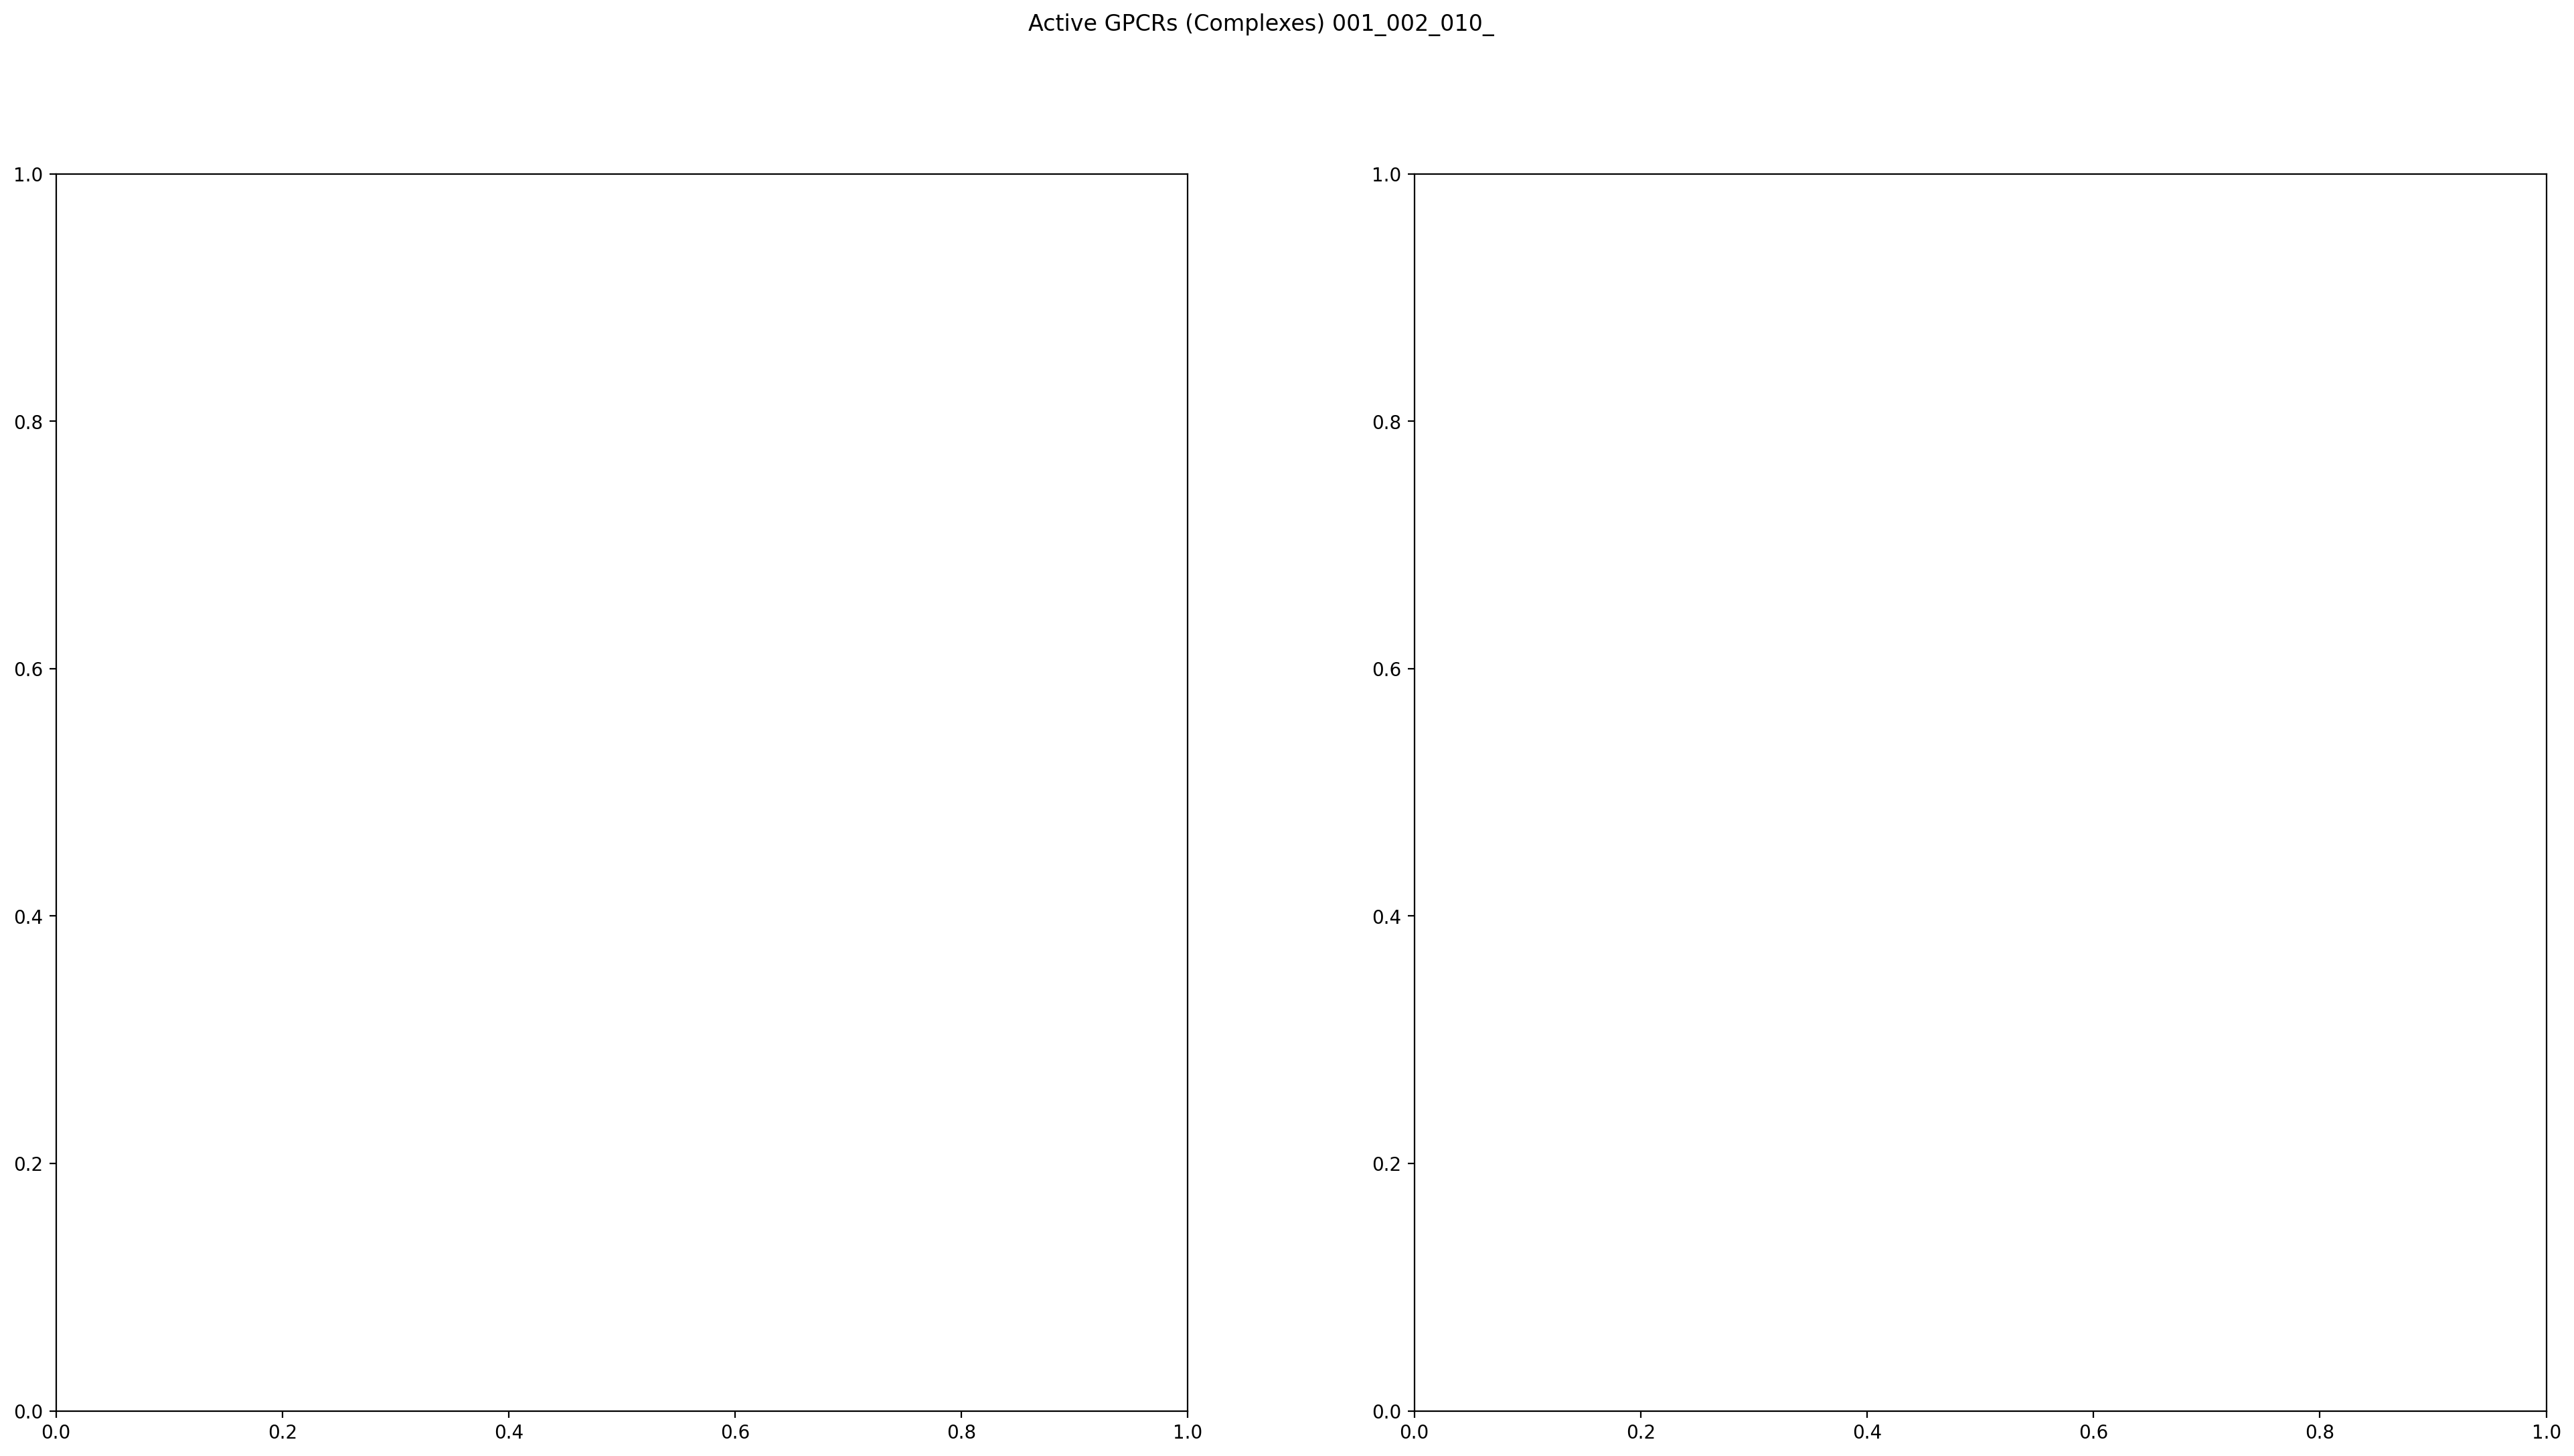

In [128]:
plot_angles_for_gen_pos(active_dfl, region=[7.45, 7.56, 8.51, 8.54], legend=False, title='Active GPCRs (Complexes) '+family_name)

In [133]:
inactive_dfl_ = inactive_dfl
inactive_dfl = []

for dfl in inactive_dfl_:
    if 'gen_pos1' not in list(dfl.columns):
        pass
    else:
        inactive_dfl.append(dfl)

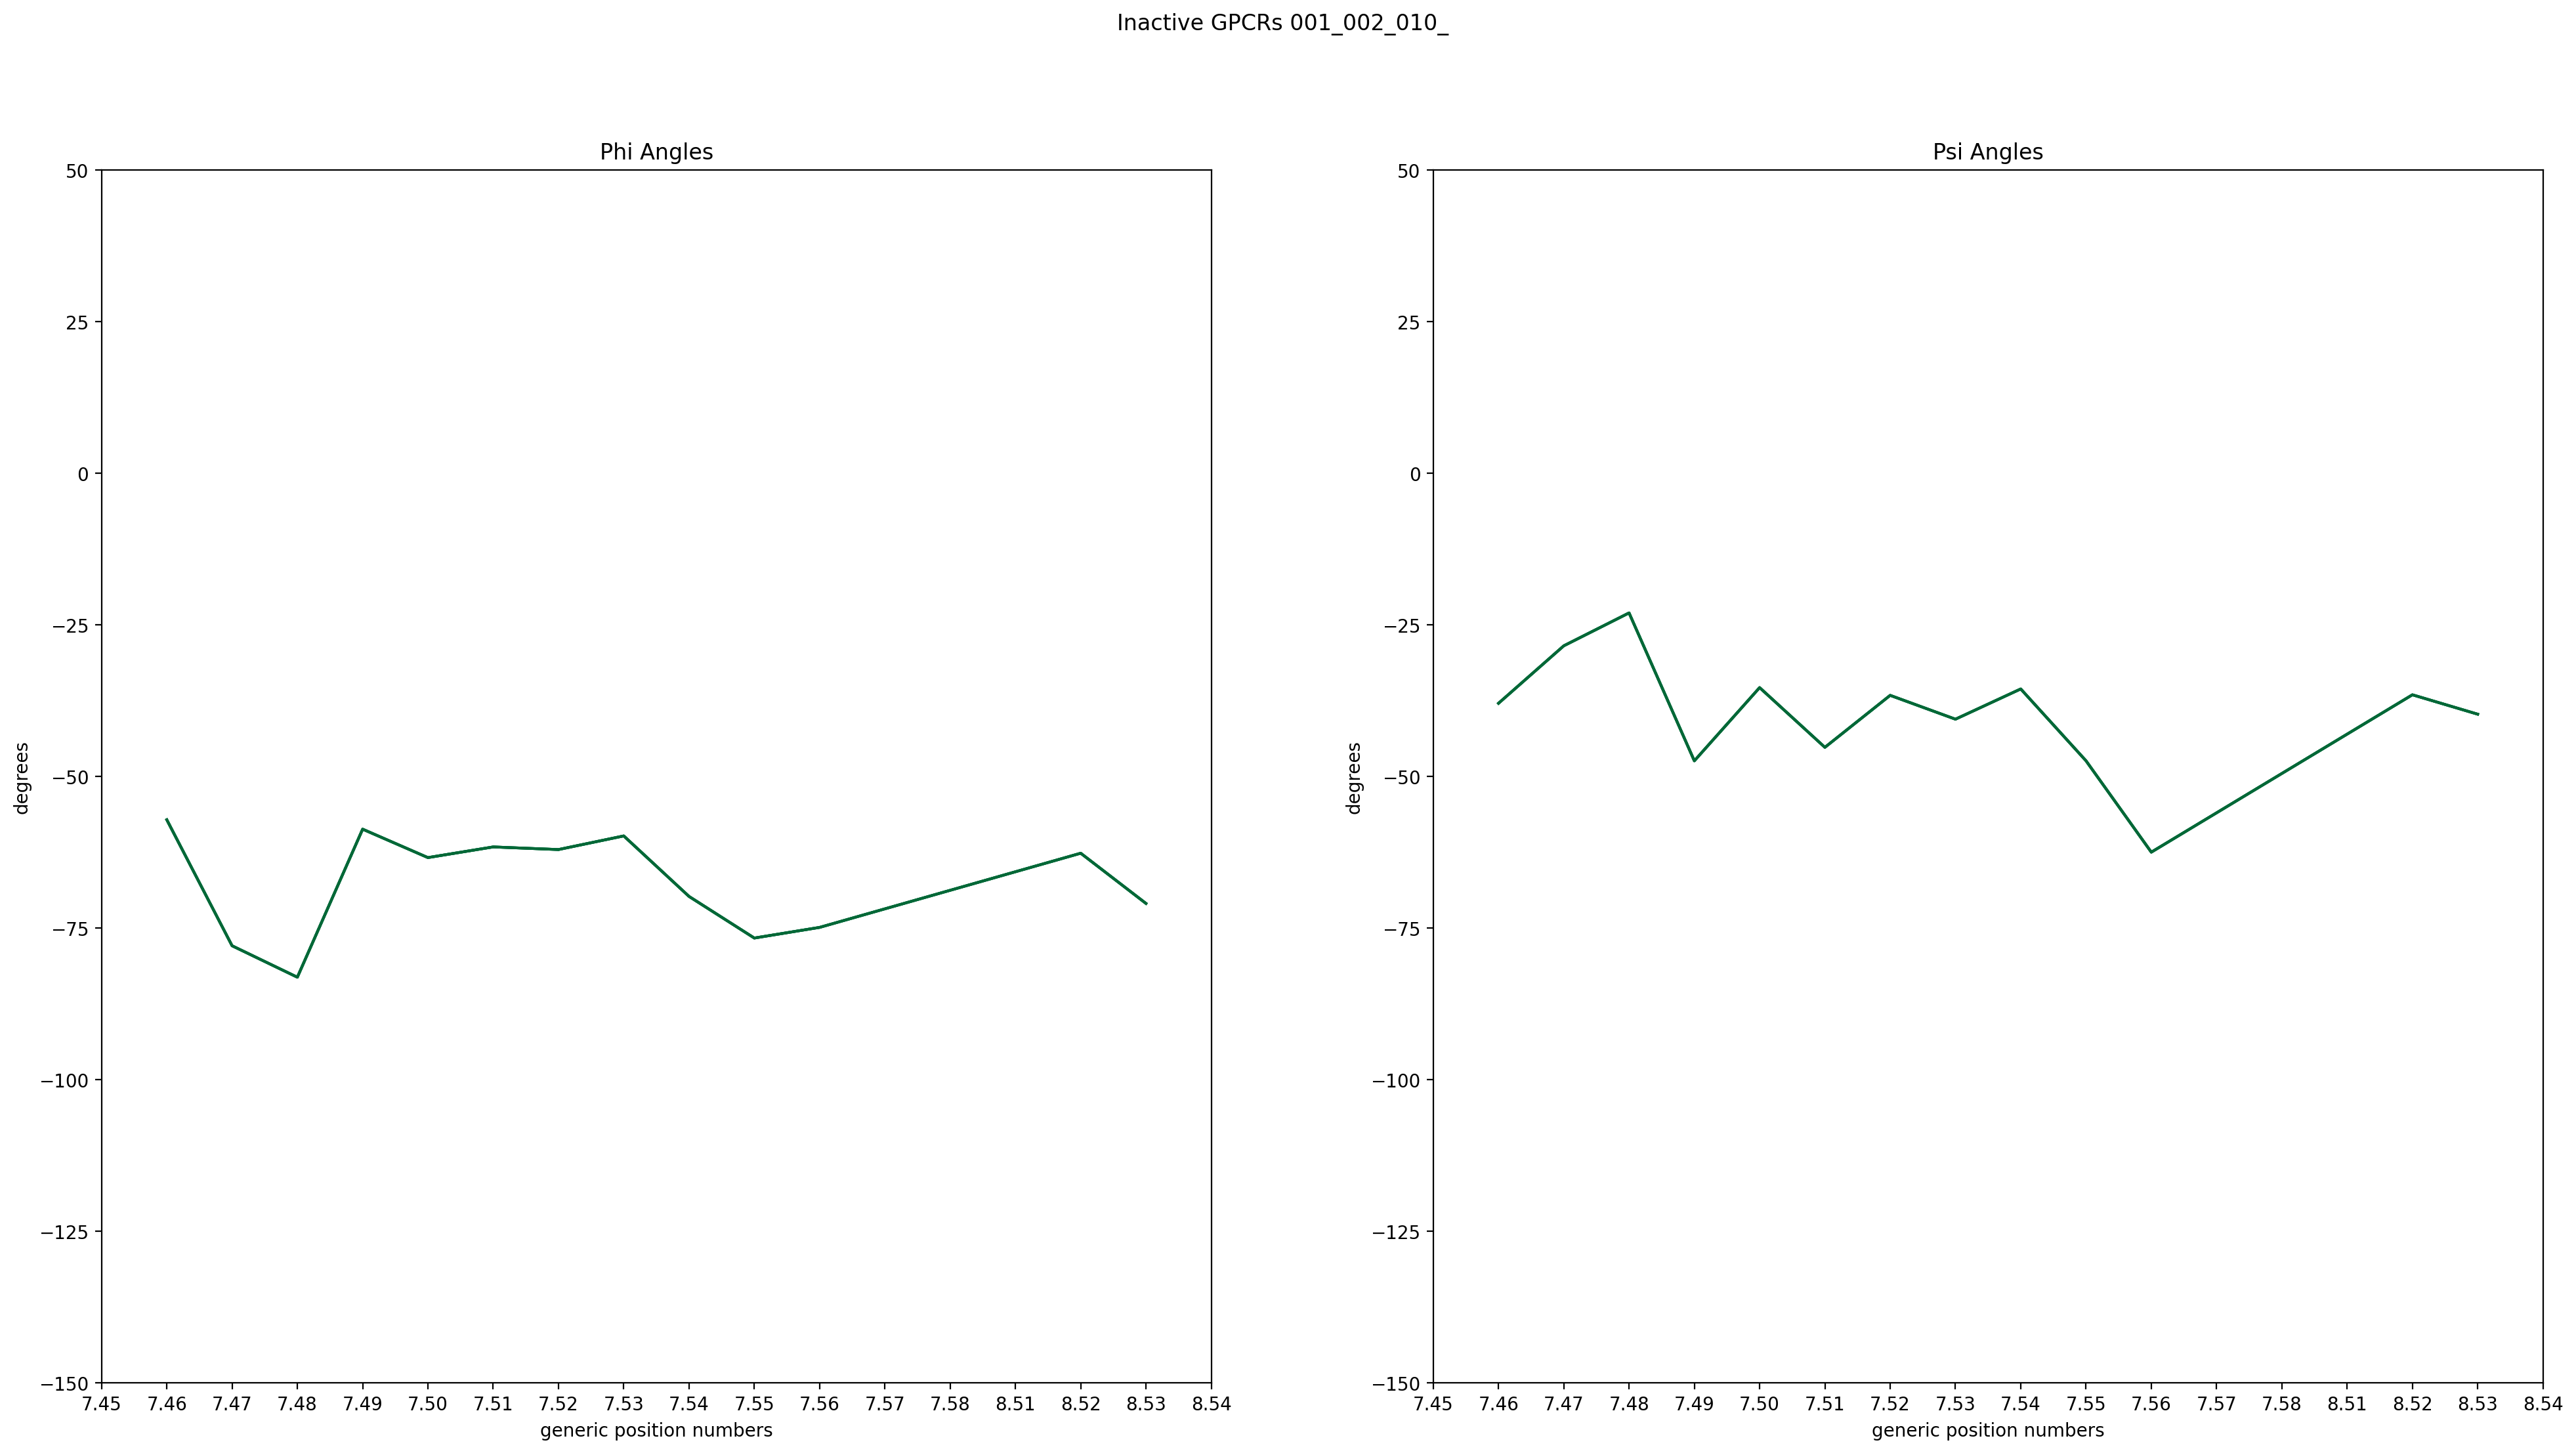

In [134]:
plot_angles_for_gen_pos(inactive_dfl, region=[7.45, 7.58, 8.51, 8.54], legend=False, title='Inactive GPCRs '+family_name)

# GPROTEINS

In [135]:
# download gproteins structures ==> where do i get regions

In [136]:
path = 'data/gproteins'

In [137]:
gproteins_table = 'data/gproteins'

In [138]:
request = ''

# AFFINITIES

In [139]:
affinities_table = 'data/couplings/'
aff_sub = affinities_table + 'subtypes_coupling.xlsx'
aff_fam = affinities_table + 'families_coupling.xlsx'

In [140]:
import pandas as pd

In [141]:
df_sub = pd.read_excel(aff_sub, header=[0,1,2], index_col=None)

In [142]:
df_sub.head(3)

Source                              Receptor  \
               Group          Biosensor                 Cl   
  Unnamed: 0_level_2 Unnamed: 1_level_2 Unnamed: 2_level_2   
0             GPCRdb               Mean                  A   
1            Bouvier              GEMTA                  A   
2              Inoue                TGF                  A   

                                                              \
         Receptor fam.            Uniprot             IUPHAR   
    Unnamed: 3_level_2 Unnamed: 4_level_2 Unnamed: 5_level_2   
0  5-Hydroxytryptamine              5HT1A             5-HT1A   
1  5-Hydroxytryptamine              5HT1A             5-HT1A   
2  5-Hydroxytryptamine              5HT1A             5-HT1A   

  Guide to Pharmacology                                        \
                     Gs               Gi/o              Gq/11   
     Unnamed: 6_level_2 Unnamed: 7_level_2 Unnamed: 8_level_2   
0                     -                 1'                  -   
1                     -                 1'                  -   
2                     -                 1'                  -   

                      ...  Emax                                          \
              G12/13  ...  Gi/o                 Gq/11                     
  Unnamed: 9_level_2  ... GNAI2 GNAI3 GNAZ GNAO  GNAQ GNA11 GNA14 GNA15   
0                  -  ...    50    39   44   52     -     -    27    52   
1                  -  ...    54     0   52   57     0     0    14    75   
2                  -  ...    45    39   35   48    41    41    40    28   

                
  G12/13        
   GNA12 GNA13  
0      -     -  
1      0     0  
2     26    21  

[3 rows x 49 columns]

In [143]:
df_fam = pd.read_excel(aff_fam, header=[0, 1], index_col=None)

In [144]:
df_fam

Source           Receptor                                          \
       Group Biosensor       Cl           Receptor fam. Uniprot  IUPHAR   
0     GPCRdb       Max        A     5-Hydroxytryptamine   5HT1A  5-HT1A   
1    Bouvier     GEMTA        A     5-Hydroxytryptamine   5HT1A  5-HT1A   
2      Inoue       TGF        A     5-Hydroxytryptamine   5HT1A  5-HT1A   
3     GPCRdb       Max        A     5-Hydroxytryptamine   5HT1B  5-HT1B   
4    Bouvier     GEMTA        A     5-Hydroxytryptamine   5HT1B  5-HT1B   
..       ...       ...      ...                     ...     ...     ...   
412  Bouvier     GEMTA        C  Metabotropic glutamate    GRM5   mGlu5   
413   GPCRdb       Max        C  Metabotropic glutamate    GRM6   mGlu6   
414  Bouvier     GEMTA        C  Metabotropic glutamate    GRM6   mGlu6   
415   GPCRdb       Max        C  Metabotropic glutamate    GRM8   mGlu8   
416  Bouvier     GEMTA        C  Metabotropic glutamate    GRM8   mGlu8   

    Guide to Pharmacology                    ... Log(Emax/EC50)          \
                       Gs Gi/o Gq/11 G12/13  ...           Gq/11 G12/13   
0                       -   1'     -      -  ...             6.7      -   
1                       -   1'     -      -  ...             6.7      0   
2                       -   1'     -      -  ...             6.7    5.3   
3                       -   1'     -      -  ...             6.7      -   
4                       -   1'     -      -  ...             6.2      0   
..                    ...  ...   ...    ...  ...             ...    ...   
412                    2'   2'    1'      -  ...             5.8      0   
413                     -   1'     -      -  ...               -      -   
414                     -   1'     -      -  ...               0      0   
415                     -   1'     -      -  ...               -      -   
416                     -   1'     -      -  ...               0      0   

    pEC50                    Emax                     
        Gs Gi/o Gq/11 G12/13    Gs Gi/o Gq/11 G12/13  
0        -  8.6   7.1      -     -   68    75      -  
1        0  8.6   6.8      0     0   68    75      0  
2      5.9    7   7.1    5.9    20   48    41     26  
3        -  9.6   7.4      -     -   33    22      -  
4        0  9.6   7.2      0     0   33    11      0  
..     ...  ...   ...    ...   ...  ...   ...    ...  
412      0  5.8   6.3      0     0   52    45      0  
413      -  5.3     -      -     -   36     -      -  
414      0  5.3     0      0     0   36     0      0  
415      -  6.1     -      -     -   45     -      -  
416      0  6.1     0      0     0   45     0      0  

[417 rows x 22 columns]

In [145]:
df_fam_gpcrdb = df_fam[df_fam['Source', 'Group']=='GPCRdb']

In [146]:
df_fam_gpcrdb.columns

MultiIndex([(               'Source',         'Group'),
            (               'Source',     'Biosensor'),
            (             'Receptor',            'Cl'),
            (             'Receptor', 'Receptor fam.'),
            (             'Receptor',       'Uniprot'),
            (             'Receptor',        'IUPHAR'),
            ('Guide to Pharmacology',            'Gs'),
            ('Guide to Pharmacology',          'Gi/o'),
            ('Guide to Pharmacology',         'Gq/11'),
            ('Guide to Pharmacology',        'G12/13'),
            (      'Log(Emax/EC50) ',            'Gs'),
            (      'Log(Emax/EC50) ',          'Gi/o'),
            (      'Log(Emax/EC50) ',         'Gq/11'),
            (      'Log(Emax/EC50) ',        'G12/13'),
            (               'pEC50 ',            'Gs'),
            (               'pEC50 ',          'Gi/o'),
            (               'pEC50 ',         'Gq/11'),
            (               'pEC50 ',        'G1

In [147]:
measurements = df_fam_gpcrdb['Receptor', 'Uniprot'].unique()

In [148]:
list(measurements)

['5HT1A',
 '5HT1B',
 '5HT1D',
 '5HT1E',
 '5HT1F',
 '5HT2A',
 '5HT2B',
 '5HT2C',
 '5HT4R',
 '5HT6R',
 '5HT7R',
 'AA1R',
 'AA2AR',
 'AA2BR',
 'AA3R',
 'ACM1',
 'ACM2',
 'ACM3',
 'ACM4',
 'ACM5',
 'ADA1B',
 'ADA1D',
 'ADA2A',
 'ADA2B',
 'ADA2C',
 'ADRB1',
 'ADRB2',
 'ADRB3',
 'AGTR1',
 'APJ',
 'BKRB1',
 'BKRB2',
 'C5AR1',
 'CCKAR',
 'CCR5',
 'CCR6',
 'CLTR1',
 'CLTR2',
 'CML1',
 'CNR1',
 'CNR2',
 'CXCR2',
 'CXCR4',
 'CXCR5',
 'DRD1',
 'DRD2',
 'DRD3',
 'DRD4',
 'DRD5',
 'EDNRA',
 'EDNRB',
 'FFAR1',
 'FFAR2',
 'FFAR3',
 'FFAR4',
 'FPR1',
 'FPR2',
 'GALR1',
 'GALR2',
 'GALR3',
 'GASR',
 'GHSR',
 'GNRHR',
 'GP119',
 'GP132',
 'GP174',
 'GP183',
 'GPBAR',
 'GPR17',
 'GPR34',
 'GPR35',
 'GPR39',
 'GPR4',
 'GPR55',
 'GPR84',
 'GRPR',
 'HCAR2',
 'HCAR3',
 'HRH1',
 'HRH2',
 'HRH3',
 'HRH4',
 'KISSR',
 'LPAR1',
 'LPAR2',
 'LPAR3',
 'LPAR4',
 'LPAR5',
 'LPAR6',
 'LT4R1',
 'LT4R2',
 'MC3R',
 'MC4R',
 'MC5R',
 'MCHR1',
 'MCHR2',
 'MRGX1',
 'MRGX2',
 'MSHR',
 'MTLR',
 'MTR1A',
 'MTR1B',
 'NK1R',
 'NK2

In [149]:
len(measurements)

173

In [150]:
class AffinityProcessor:
    def __init__(self,
                 path='data/couplings/',
                 file='families_coupling.xlsx'):
        self.y_types = ['Guide to Pharmacology', 'Log(Emax/EC50) ', 'pEC50 ', 'Emax ']
        if 'sub' in file:
            self.mode='sub'
            self.data = pd.read_excel(path+file, header=[0, 1, 2], index_col=None)
        else:
            self.mode='fam'
            self.data = pd.read_excel(path+file, header=[0, 1], index_col=None)
        
    
    def __len__(self):
        return len(self.data)
    
    def filter_group(self, group='GPCRdb'):
        if self.mode=='fam':
            self.data = self.data[self.data['Source', 'Group']==group]
        else:
            self.data = self.data[self.data['Source', 'Group', 'Unnamed: 0_level_2']==group]
        
    def filter_aff_type(self, y_type='pEC50 '):
        cols_to_drop = [x for x in self.y_types if x != y_type]
        self.data = self.data.drop(cols_to_drop, axis = 1)
    
    def get_genes(self):
        if self.mode=='fam':
            return list(self.data['Receptor', 'Uniprot'].unique())
        else:
            return list(self.data['Receptor', 'Uniprot', 'Unnamed: 4_level_2'].unique())

In [151]:
class SequenceProcessor:
    def __init__(self):
        pass
    # I need a class / function to handle the calls to get the uniprot sequence with generic sequence numbers

In [152]:
AP = AffinityProcessor()

In [153]:
AP.__len__()

417

In [154]:
AP.filter_group()

In [155]:
AP.filter_aff_type()

C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\pandas\core\generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [156]:
genes_ = AP.get_genes()

In [157]:
# genes

In [158]:
# genes_

# DATALOADER

In [ ]:
class DataLoader:
    def __init__(self,
                 setting=0):
        self.setting_dict = {
            0: 'seq_to_contact_maps',
            1: 'struct_to_contact_maps',
            2: 'selectivity_from_maps',
            3: 'seq_to_weights',
            4: 'inact_struct_to_weights',
            5: 'act_struct_to_weights',
            6: 'phi_psi'
        }
        
        self.setting = setting
        
        if self.setting not in self.setting_dict.keys():
            print("Unavailable setting number! Please chose a valid setting number ==> ", self.setting_dict.keys())
            return None
        
        print("Using setting {} ({}).".format(self.setting, self.setting_dict[self.setting]))
        # DEPENDING ON SETTINGS WE LOAD DIFFERENT DATASETS AND COMBINE THEM TO FORM *SAMPLES*
        
        if self.setting == 0:
            # have to load active complexes 
            # have to calc dists / contacts
            # x=sequences of lock and key, y = contacts
            pass
        elif self.setting == 1:
            # have to load active complexes
            # have to calc dists / contacts
            # x=structs of lock and key, y = contacts
            pass
        elif self.setting == 2:
            # load active complexes
            # calc dists / contacts
            # predict selectivity
            pass
        elif self.setting == 3:
            # load seqs (uniprot) for each gene with associated affinities
            # predict selectivity
            # evaluate weights after
            pass
        elif self.setting == 4:
            # load inactive structures
            # cross reference affinities (based on uniprot)
            # select region based on generic residue number
            # predict selectivity
            # evaluate weights after
            pass
        elif self.setting == 5:
            # load active states
            # we could use *false* inputs by swapping the c-tail of different gproteins in a manner where they "fit into the pocket"
            # predict selectivity
            # evaluate weights after
            pass
        elif self.setting == 6:
            # select region with generic residue numbers
            # calculate psi / phi of active inactive complexes
            # calculate deltas
            # predict deltas / final state (input can either be psi and phi or just the residue type)
            pass
        
    def __getitem__(self, idx):
        return self.data.iloc[idx]
    
    def init_data(self):
        pass
    
    def get_seq(self):
        pass
    
    def get_struct(self, CifProcessor):
        # based on setting
        pass

In [ ]:
dl = DataLoader(0)

In [ ]:
# TBD: 
# structure to distances (active complexes) ==> the other chain...
# 

# NNS

In [ ]:
from networks import *

## predict contact maps based on sequence

## predict contact maps based on structures (inactive)

## predict selectivity based on contact maps

## predict selectivity based on sequence -> evaluate weights to create interaction weights

## predict selectivity based on structure (only inactive pocket) -> evaluate weights to create interaction weights

## predict selectivity based on structure (active pocket + c-tail) -> evaluate weights to create interaction weights

# Thoughts?

Maybe have a look in the plots at how variant the icl4 is within its own groups in the inactive state,
this will have a big influence on setting 6 and structure based approaches if flexibility is present in the inactive state.
For sequence based approaches this may be irrelevant..